In [ ]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
import glob
import matplotlib.pyplot as plt
import act
import xarray as xr
import scipy.signal
import datetime as dt
import scipy
import altair as alt

# User Inputs

In [ ]:
ds_dl_fpt = 'gucdlfptM1.b1'
startdate = '2022-10-30'
enddate = '2022-10-30'
SNR_THRESHOLD = 0.008

In [ ]:
username='eschwat'
token='761cf7339f9adaec'


In [ ]:
username, token

# Download datasets

In [ ]:
act.discovery.download_data(username, token, ds_dl_fpt, startdate, enddate)
!du -sh gucdlfptM1.b1 

In [56]:
dl_fpt_files = glob.glob(''.join(['./',ds_dl_fpt,'/*cdf']))

In [57]:
dl_fpt = act.io.armfiles.read_netcdf(dl_fpt_files)

# Resample to the minute (without inteprolating missing minutes) and limit range

In [59]:
dl_fpt.coords['time'] = dl_fpt.time.dt.floor('1Min')
dl_fpt = dl_fpt.groupby('time').mean()
dl_fpt = dl_fpt.sel(range=slice(0,4000))

# Calculate SNR (do not filterr)

In [61]:
dl_fpt['SNR'] = dl_fpt['intensity'] - 1
# dl_fpt['radial_velocity'] = dl_fpt.where(dl_fpt['SNR'] > SNR_THRESHOLD)['radial_velocity']

<AxesSubplot: title={'center': 'Gothic Doppler LiDAR radial_velocity on 20221030'}, xlabel='Time [UTC]', ylabel='(m)'>

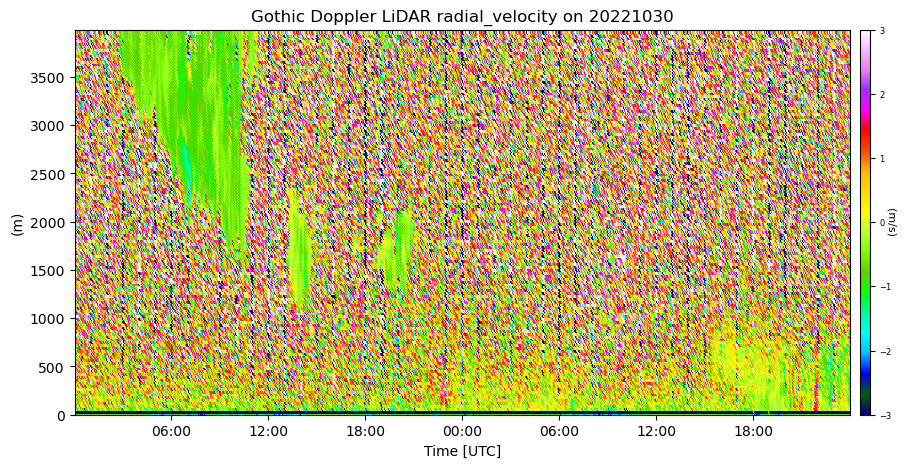

In [62]:
display = act.plotting.TimeSeriesDisplay(
    {'Gothic Doppler LiDAR': dl_fpt},
    subplot_shape=(1,),
    figsize=(10, 5),
)

display.plot(
    'radial_velocity',
    dsname='Gothic Doppler LiDAR',
    cmap='gist_ncar',
    vmin=-3,
    vmax=3,
    subplot_index=(0,)
)


# Create DF

In [63]:
src_fpt = dl_fpt.to_dataframe().reset_index()

In [64]:
src_fpt

range                time  qc_time     azimuth  elevation  \
0         15.0 2022-10-30 00:01:00     4.00  259.110016  90.000000   
1         15.0 2022-10-30 00:04:00     4.00  259.089966  90.000000   
2         15.0 2022-10-30 00:07:00     0.25  259.100006  89.998749   
3         15.0 2022-10-30 00:08:00     0.00  259.099976  90.000000   
4         15.0 2022-10-30 00:09:00     0.00  259.099976  90.000000   
...        ...                 ...      ...         ...        ...   
350716  3975.0 2022-10-31 23:55:00     0.00  259.099976  90.000000   
350717  3975.0 2022-10-31 23:56:00     0.00  259.099976  90.000000   
350718  3975.0 2022-10-31 23:57:00     0.00  259.099976  90.000000   
350719  3975.0 2022-10-31 23:58:00     0.00  259.099976  90.000000   
350720  3975.0 2022-10-31 23:59:00     0.00  259.099976  90.000000   

        radial_velocity  qc_radial_velocity  intensity  \
0             -0.726200                 0.0   1.051719   
1             -0.688000                 0.0   0.948749   
2             -0.730969                 0.0   0.983543   
3             -0.699171                 0.0   0.953938   
4             -0.705451                 0.0   0.956676   
...                 ...                 ...        ...   
350716        -3.022004                 0.0   1.001341   
350717        -1.029315                 0.0   1.001743   
350718        -0.925710                 0.0   1.001438   
350719         3.716610                 0.0   1.001221   
350720         2.276381                 0.0   1.001579   

        attenuated_backscatter        lat         lon     alt       SNR  
0                 2.912599e-06  38.956158 -106.987854  2886.0  0.051719  
1                -2.886243e-06  38.956158 -106.987854  2886.0 -0.051251  
2                -9.267811e-07  38.956158 -106.987854  2886.0 -0.016457  
3                -2.593991e-06  38.956154 -106.987854  2886.0 -0.046062  
4                -2.439815e-06  38.956154 -106.987854  2886.0 -0.043324  
...                        ...        ...         ...     ...       ...  
350716            6.011275e-07  38.956154 -106.987854  2886.0  0.001341  
350717            7.810492e-07  38.956154 -106.987854  2886.0  0.001743  
350718            6.443598e-07  38.956154 -106.987854  2886.0  0.001438  
350719            5.473150e-07  38.956154 -106.987854  2886.0  0.001221  
350720            7.077579e-07  38.956154 -106.987854  2886.0  0.001579  

[350721 rows x 13 columns]

Make power spectral density functions of the wind speed measured by the vertical stares for:

1. All of the SAIL data to date
2. All data from last winter
3. All data from last spring

Let's see what the power spectral density function looks like by time period ranging from **twice the frequency of the vertical stares that the DL collects** out to a **period of one month**  

There should be a few peaks at daily and sub-daily intervals, Hopefully things at sub-hourly periods are not impacted. Hopefully there aren't too many gaps, because FFTs don't work with gaps.  I trust your judgement for something simple to fill in gaps.  You may consider doing this (https://stackoverflow.com/questions/23083649/fourier-transformation-with-missing-values).


Notes:
* ignore anything above 3km
* break time series into pieces 

# Calculate power spectral density function for a range of 1995 meters

In [65]:
lim_src_fpt = src_fpt.query('range == 1995')

# Demean radial velocity, add epoch information, add samp

In [74]:
lim_src_fpt['radial_velocity_demeaned'] = lim_src_fpt['radial_velocity'] - np.nanmean(lim_src_fpt['radial_velocity'])
lim_src_fpt['epoch'] = (lim_src_fpt['time'] - dt.datetime(1970,1,1)).dt.total_seconds()

/tmp/ipykernel_359103/1425996224.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lim_src_fpt['radial_velocity_demeaned'] = lim_src_fpt['radial_velocity'] - np.nanmean(lim_src_fpt['radial_velocity'])
/tmp/ipykernel_359103/1425996224.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lim_src_fpt['epoch'] = (lim_src_fpt['time'] - dt.datetime(1970,1,1)).dt.total_seconds()


In [75]:
freqs = np.linspace(1/(3600*24),1/120, 100)
pgram = scipy.signal.lombscargle(
    lim_src_fpt[['epoch', 'radial_velocity_demeaned']].dropna()['epoch'],
    lim_src_fpt[['epoch', 'radial_velocity_demeaned']].dropna()['radial_velocity_demeaned'],
    freqs
)


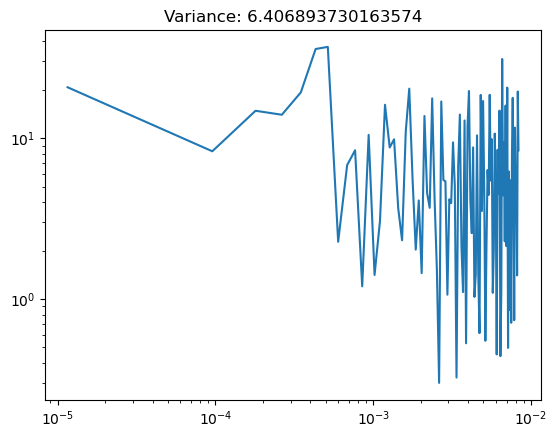

In [86]:
var = np.var(lim_src_fpt['radial_velocity_demeaned'])
plt.loglog(freqs, pgram)
plt.title(f'Variance: {var}')
plt.show()

In [72]:
lim_src_fpt['minutes'] = lim_src_fpt['time'].dt.minute

/tmp/ipykernel_359103/647543850.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lim_src_fpt['minutes'] = lim_src_fpt['time'].dt.minute


In [73]:
alt.Chart(lim_src_fpt).mark_bar().encode(
    alt.X('minutes:Q'),
    y='count()'
)

/home/elilouis/miniconda3/envs/arm/lib/python3.11/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

In [71]:
alt.Chart(lim_src_fpt).mark_tick().encode(
    alt.X('minutes(time):T')
).properties(width=1000,height=200)

alt.Chart(...)

# Repeat with some data removed

In [90]:
modeled_missing_lim_src_fpt = lim_src_fpt[~lim_src_fpt['minutes'].isin([
    11,12,13,14,15,
    26,27,28,29,30,
    41,42,43,44,45,
    56,57,58,59, 0
])]

In [91]:
freqs = np.linspace(1/(3600*24),1/120, 100)
pgram = scipy.signal.lombscargle(
    modeled_missing_lim_src_fpt[['epoch', 'radial_velocity_demeaned']].dropna()['epoch'],
    modeled_missing_lim_src_fpt[['epoch', 'radial_velocity_demeaned']].dropna()['radial_velocity_demeaned'],
    freqs
)


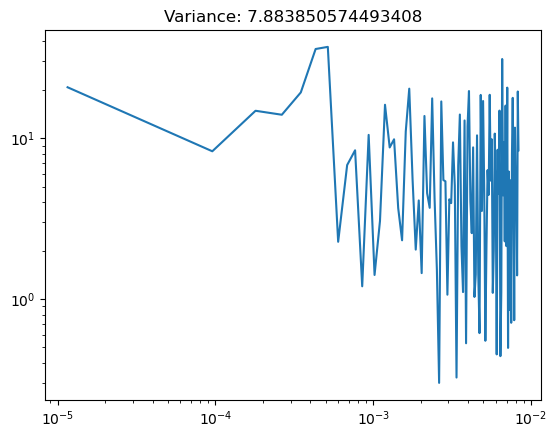

In [92]:
var = np.var(modeled_missing_lim_src_fpt['radial_velocity_demeaned'])
plt.loglog(freqs, pgram)
plt.title(f'Variance: {var}')
plt.show()

In [93]:
modeled_missing_lim_src_fpt['minutes'] = modeled_missing_lim_src_fpt['time'].dt.minute

/tmp/ipykernel_359103/2079411636.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modeled_missing_lim_src_fpt['minutes'] = modeled_missing_lim_src_fpt['time'].dt.minute


In [94]:
alt.Chart(modeled_missing_lim_src_fpt).mark_bar().encode(
    alt.X('minutes:Q'),
    y='count()'
)

/home/elilouis/miniconda3/envs/arm/lib/python3.11/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

In [95]:
alt.Chart(modeled_missing_lim_src_fpt).mark_tick().encode(
    alt.X('minutes(time):T')
).properties(width=1000,height=200)

alt.Chart(...)

Statistics: 

* Compute variance of time series - is it same for different 10 minute chunks? is it same for a 40 minute period and for a 10 minute period? 
* Plot: variance on y axis - window length on x axis